In [15]:
## Quantum Key Distribution

In [16]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex
from numpy.random import randint

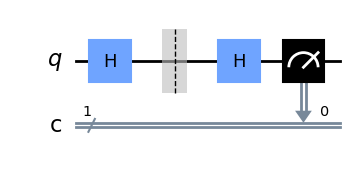

In [17]:
qc = QuantumCircuit(1, 1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
#   who measures it in the X-basis
qc.h(0)
qc.measure(0, 0)

# Draw and simulate the circuit
qc.draw('mpl')

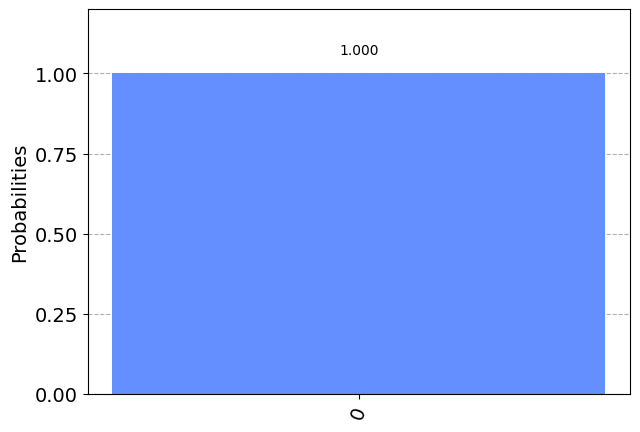

In [18]:
svs = Aer.get_backend('qasm_simulator')
job = execute(qc, svs)
plot_histogram(job.result().get_counts())

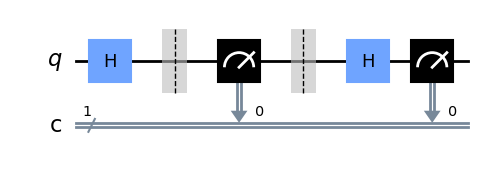

In [19]:
qc = QuantumCircuit(1, 1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()

# Eve intercepts the qubit, but measures in the wrong basis
qc.measure(0, 0)
qc.barrier()

# Alice now sends the qubit to Bob
#   who measures it in the X-basis
qc.h(0)
qc.measure(0, 0)

# Draw and simulate the circuit
qc.draw('mpl')

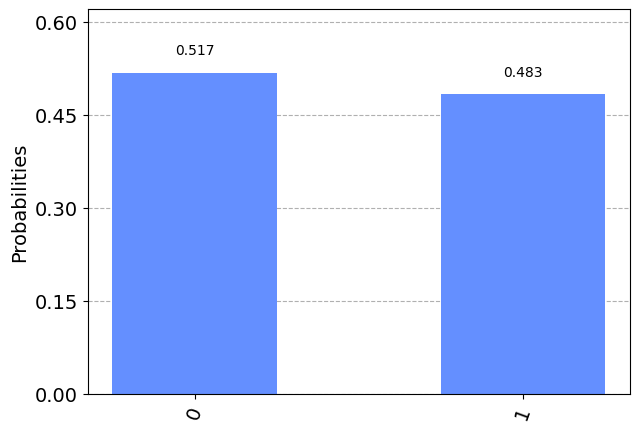

In [20]:
svs = Aer.get_backend('qasm_simulator')
job = execute(qc, svs)
plot_histogram(job.result().get_counts())

In [21]:
np.random.seed(seed=0)
n = 100

In [22]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1, 1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0, 0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0, 0)
        result = execute(message[q], backend, shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            #   this to list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # Use np.mod to make sure the
        #   bit we sample is always in
        #   the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        #   list at index 'i'
        sample.append(bits.pop(i))
    return sample

In [23]:
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
#   are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decided which basis to measure in
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = " + str(alice_sample))
if bob_sample == alice_sample:
    print("Key is safe")
else:
    print("Key is compromized")
print("Efficiency: " + str(len(bob_key) / n))

bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Key is safe
Efficiency: 0.33


In [24]:
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
#   are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

# Eve has intercepted the message
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)

## Step 3
# Decided which basis to measure in
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = " + str(alice_sample))
if bob_sample == alice_sample:
    print("Key is safe")
else:
    print("Key is compromized")
print("Efficiency: " + str(len(bob_key) / n))

different_bits = 0
for i in range(sample_size):
    if alice_sample[i] != bob_sample[i]:
        different_bits += 1
print("Different bits: " + str(different_bits))

bob_sample = [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
alice_sample = [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Key is compromized
Efficiency: 0.38
Different bits: 6
